Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Bence Keresztury"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
len(env.P[1][0])

1

In [7]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    
    V = np.zeros(env.nS)
    while True:
        # YOUR CODE HERE
        new_V = np.zeros(env.nS)
        for s in range(env.nS):
            summ = 0;
            for a in range(env.nA):
                q_value = 0
               
                for j in range(len(env.P[s][a])): 
                    q_value += policy[s][a]* (env.P[s][a][j][0]*(env.P[s][a][j][2]+discount_factor*V[env.P[s][a][j][1]]))
            
                summ += q_value
            new_V[s] = summ 
            
        diff = np.abs(new_V-V)
        if all(diff<theta):
            V = new_V
            break
        else:
            V = new_V
            
        
    return np.array(V)

In [8]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99989315, -19.99984167, -21.99982282,
       -13.99989315, -17.99986052, -19.99984273, -19.99984167,
       -19.99984167, -19.99984273, -17.99986052, -13.99989315,
       -21.99982282, -19.99984167, -13.99989315,   0.        ])

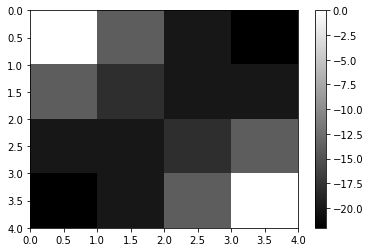

In [9]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [10]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [11]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        
        # YOUR CODE HERE
        new_policy = np.zeros((env.nS, env.nA))
        for s in range(env.nS):
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                action_values[a]= V[env.P[s][a][0][1]]
            best_action = np.argmax(action_values)
            new_policy[s][best_action] = 1
        
        if not np.array_equal(new_policy, policy):
            policy=new_policy
        else:
            break
            
    # ToDO: One danger: policy switches between optimal strategies all the time!
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



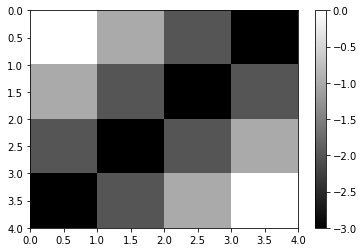

In [12]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [13]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [14]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    # Implement!
    # YOUR CODE HERE
    #finding optimal value function
    while True:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for j in range(len(env.P[s][a])):
                    action_values[a] += env.P[s][a][j][0] * (env.P[s][a][j][2] + discount_factor * V[env.P[s][a][j][1]])
            V[s] = np.max(action_values)
            delta = max(delta, abs(V[s]-v))
        if delta<theta:
            break

    #policy extraction step
    new_policy = np.zeros((env.nS, env.nA))
    for s in range(env.nS):
        action_values = np.zeros(env.nA)
        for a in range(env.nA):
            action_values[a]= V[env.P[s][a][0][1]]
        best_action = np.argmax(action_values)
        new_policy[s][best_action] = 1
        policy=new_policy


    
    return policy, V

In [15]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Policy iteration includes policy evaluation and policy improvement steps and these are repeated until convergence. Policy evaluation is performed until the exact values are reached (with a small error margin). Value iteration consits of finding the optimal value function and a policy extraction step. While finding the optimal value, we implicitly update the policy by taking the argmax action based on the current values. After we found the optimal values, we can extract the optimal policies by taking the best action at every state. 

Efficiency:
Policy iteration converges usually in suprisingly few steps, however for every step it needs to calculate the values (almost) exactly. The policy based on the approximated value function however, does not change after a couple iterations (so it is redundant to calculate the exact values of a policy which we are going to change), therefore value iteration can often be more efficient (it approximates the value of a policy based on one iteration). 

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

Monte Carlo methods do not assume complete knowledge of the environment. Using DP algorithms are very useful if we know the exact transition probabilities and reward distribution, however in full reinforcement learning problems usually we don't know them and we want to discover them. In these cases we can use Monta Carlo algorithms for estimating the probabilities based on experience of the agent (no prior knowledge required). 

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [16]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [17]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [18]:
# We can also look at the documentation/implementation of a method
?env.step

In [19]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [20]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    # YOUR CODE HERE
    if observation[0]<20:
        return 1
    else:
        return 0

In [23]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(13, 10, False)
((17, 10, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [24]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        #generating episode
        s = env.reset()
        initial_state = s

        T=0
        outcome = {}
        while True:
            action = policy(s)
            T=T+1
            outcome[T] = env.step(action)
            
            s = outcome[T][0]
            #if the eposide ended
            G = 0
            if outcome[T][2]==True:
                for t in range(T-1,-1,-1):
                    if t!=0:
                        current_state = outcome[t][0]
                    else:
                        current_state = initial_state
                    G+= discount_factor * outcome[t+1][1]
                    returns_sum[current_state] += G
                    returns_count[current_state] += 1
                    V[current_state] = returns_sum[current_state]/returns_count[current_state]
                break
    return V

In [25]:
V = mc_prediction(simple_policy, env, num_episodes=1000)

100%|██████████| 1000/1000 [00:00<00:00, 14669.91it/s]


Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [26]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:25<00:00, 19400.16it/s]

CPU times: user 26.2 s, sys: 10.8 ms, total: 26.2 s
Wall time: 26.2 s


In [27]:
print(V_500k[(16,10,True)])

-0.39471544715447154


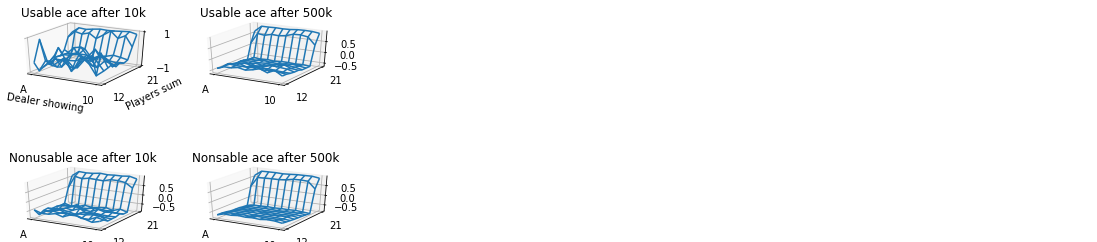

In [28]:
# YOUR CODE HERE
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

ax2 = fig.add_subplot(2,2,2, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

ax3 = fig.add_subplot(2,2,3, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

ax4 = fig.add_subplot(2,2,4, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

fig.subplots_adjust(hspace=1)

z_usable_10k = np.zeros((10,10))
z_nonusable_10k = np.zeros((10,10))
z_usable_500k = np.zeros((10,10))
z_nonusable_500k = np.zeros((10,10))



for player in range(12,22):
    for dealer in range(1,11):
        z_usable_10k[player-12][dealer-1] = V_10k[(player, dealer, True)]
        z_nonusable_10k[player-12][dealer-1] = V_10k[(player, dealer, False)]
        z_usable_500k[player-12][dealer-1] = V_500k[(player, dealer, True)]
        z_nonusable_500k[player-12][dealer-1] = V_500k[(player, dealer, False)]
Y_grid = np.tile(np.expand_dims(np.arange(12,22), 1), (1,10))
X_grid = np.tile(np.expand_dims(np.arange(1,11), 0), (10,1))


ax1.set_xlabel('Dealer showing')
ax1.set_ylabel('Players sum')
ax1.set_title('Usable ace after 10k')
ax2.set_title('Usable ace after 500k')
ax3.set_title('Nonusable ace after 10k')
ax4.set_title('Nonsable ace after 500k')

ax1.plot_wireframe(X_grid, Y_grid, z_usable_10k)
ax2.plot_wireframe(X_grid, Y_grid, z_usable_500k)
ax3.plot_wireframe(X_grid, Y_grid, z_nonusable_10k)
ax4.plot_wireframe(X_grid, Y_grid, z_nonusable_500k)


## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

The state value functions in itself are useless, since we don't have a model of the environment. We don't know how to get to a certain state.

In [29]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # YOUR CODE HERE
        action_probs = np.ones(nA)*epsilon/nA
        action_values = Q[observation]
        greedy_action = np.argmax(action_values)
        
        action_probs[greedy_action] += 1-epsilon
        
        return action_probs
    return policy_fn

In [30]:
def cdf(weights):
    total = sum(weights)
    assert(total==1)
    percentile = []
    cumsum = 0
    for w in weights:
        cumsum += w
        percentile.append(cumsum / total)
    return percentile

def choose_action(percentiles):
    r = np.random.rand()
    for i in range(len(percentiles)):
        if r<=percentiles[i]:
            return i
    raise Error('no choice made')


In [31]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        s = env.reset()
        initial_state = s

        T=0
        outcome = {}
        actions = []
        while True:
            action_probs = policy(s)
            action = choose_action(cdf(action_probs))
            actions.append(action)
            
            T=T+1
            
            outcome[T] = env.step(action)
            s = outcome[T][0]
            #if the eposide ended
            G = 0
            if outcome[T][2]==True:
                for t in range(T-1,-1,-1):
                    if t!=0:
                        current_state = outcome[t][0]
                    else:
                        current_state = initial_state
                    G+= discount_factor * outcome[t+1][1]

                    
                    returns_sum[current_state][actions[t]] += G
                    returns_count[current_state][actions[t]] += 1
                    
                    Q[current_state][actions[t]] = returns_sum[current_state][actions[t]]/returns_count[current_state][actions[t]]
                    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
                    
                break
        
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)  
print(policy)

100%|██████████| 10000/10000 [00:00<00:00, 10680.77it/s]

<function make_epsilon_greedy_policy.<locals>.policy_fn at 0x7fd97619a8c8>


In [32]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:47<00:00, 10583.42it/s]

CPU times: user 48.4 s, sys: 3.04 s, total: 51.4 s
Wall time: 47.2 s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

Text(0.5, 1.0, 'No usable ace')

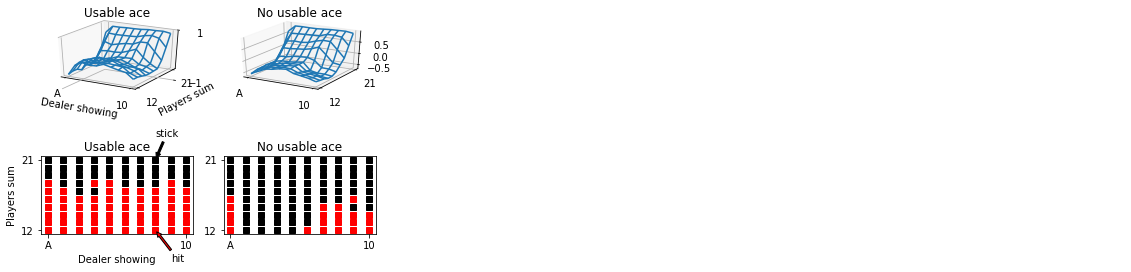

In [33]:
# YOUR CODE HERE
V = defaultdict(float)
greedy_action = defaultdict(float)
for k,v in Q.items():
    greedy_action[k] = np.argmax(v)
    V[k] = max(v)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

ax2 = fig.add_subplot(2,2,2, projection='3d')
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))
ax1.set_zticks([-1,1])

ax3 = fig.add_subplot(2,2,3)
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))

ax4 = fig.add_subplot(224)
plt.xticks((1,10),('A',10))
plt.yticks((12,21),(12,21))

fig.subplots_adjust(hspace=0.8)

z_usable = np.zeros((10,10))
z_nonusable = np.zeros((10,10))

for player in range(12,22):
    for dealer in range(1,11):
        z_usable[player-12][dealer-1] = V[(player, dealer, True)]
        z_nonusable[player-12][dealer-1] = V[(player, dealer, False)]
Y_grid = np.tile(np.expand_dims(np.arange(12,22), 1), (1,10))
X_grid = np.tile(np.expand_dims(np.arange(1,11), 0), (10,1))


ax1.set_xlabel('Dealer showing')
ax1.set_ylabel('Players sum')
ax1.set_title('Usable ace')
ax2.set_title('No usable ace')

ax1.plot_wireframe(X_grid, Y_grid, z_usable)
ax2.plot_wireframe(X_grid, Y_grid, z_nonusable)


for dealer in range(1,11):
    for player in range(12,22):
        if greedy_action[player, dealer, True]==0:
            ax3.plot(dealer, player, 's', c='k')
            
        else:
            ax3.plot(dealer, player, 's', c='r')
            
        if greedy_action[player, dealer, False]==0:
            ax4.plot([dealer], [player], 's', c='k')
        else:
            ax4.plot([dealer], [player], 's', c='r')

ax3.set_xlabel('Dealer showing')
ax3.set_ylabel('Players sum')
ax3.annotate('stick', xy=(8, 21), xytext=(8, 24),
            arrowprops=dict(arrowstyle= 'simple', facecolor='black'),
            )
ax3.annotate('hit', xy=(8, 12), xytext=(9, 8),
            arrowprops=dict(arrowstyle= 'simple', facecolor='red'),
            )
ax3.set_title('Usable ace')
ax4.set_title('No usable ace')
            

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

MC methods have the advantage (over DP methods) that they don't need a model, they are able to find optimal policy based on the interaction with the environment. One disadvantage is that they do not bootstrap, that means they do not make use of the property that values of subsequent states usually correlate with each other. An other problem is that MC methods assume episodic task and cannot be used with continuous (ongoing) tasks. TD learning is able to handle continuous tasks as well and combines the advantage of MC methods with bootstrapping. In a lot of tasks the episodes are very long and waiting till the end of an episode to update values could be too slow in a lot of applications. In these cases I would use TD methods since the build up an estimate in incremental (step by step) manner, they only need to wait untill the next step to update.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [34]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

100%|██████████| 1000/1000 [00:00<00:00, 1759.31it/s]


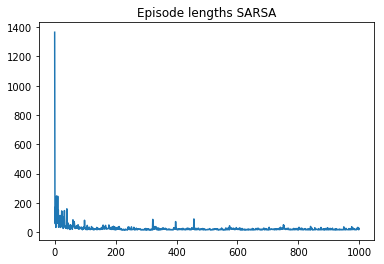

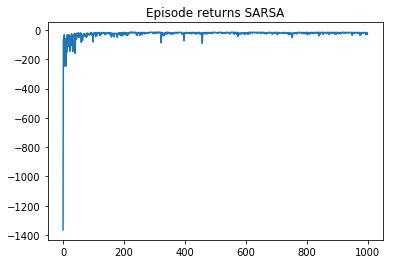

In [40]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        state = env.reset()
        while True:
            if i==0:
                action_probs = policy(state)
                action = choose_action(cdf(action_probs))
            i=i+1
            outcome = env.step(action)
            next_state = outcome[0]
            reward = outcome[1]
            R +=reward
            
            next_action = choose_action(cdf(policy(next_state)))
            
            Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_action]-Q[state][action])
            
            state = next_state
            action = next_action
            
            if outcome[2]==True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000) #oriiginal: 1000 runs

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:00<00:00, 1532.90it/s]


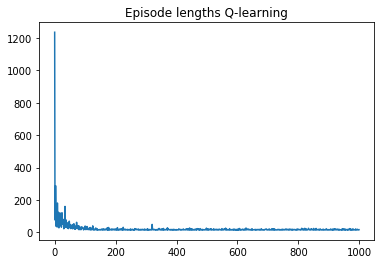

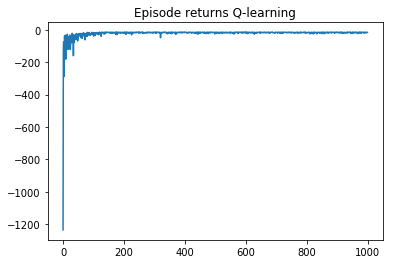

In [42]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        state = env.reset()
        while True:
            if i==0:
                action_probs = policy(state)
                action = choose_action(cdf(action_probs))
            outcome = env.step(action)
            next_state = outcome[0]
            reward = outcome[1]
            R +=reward
            
            next_action = choose_action(cdf(policy(next_state)))
            next_best_action = np.argmax(policy(next_state)) 
            
            Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_best_action]-Q[state][action])
            
            state = next_state
            action = next_action
            i=i+1

            if outcome[2]==True:
                break
            
        
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

In [37]:
# YOUR CODE HERE
num_eps = 10000
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, num_eps)
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, num_eps) 


100%|██████████| 10000/10000 [00:06<00:00, 1523.27it/s]


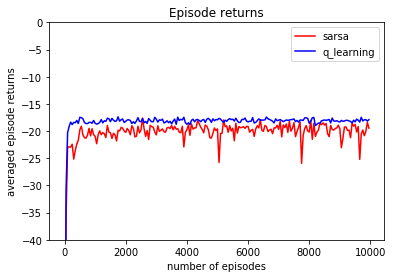

In [38]:
smooth = 50

return_avgs_sarsa = np.zeros(round(num_eps/smooth))
return_avgs_q = np.zeros(round(num_eps/smooth))

for i in range(round(num_eps/smooth)):
    return_avgs_sarsa[i] = np.mean(episode_returns_sarsa[i*smooth:(i+1)*smooth])
    return_avgs_q[i]= np.mean(episode_returns_q_learning[i*smooth:(i+1)*smooth])
plt.ylim(-40,0)
plt.xlabel('number of episodes')
plt.ylabel('averaged episode returns')
plt.plot(list(range(0, num_eps, smooth)), return_avgs_sarsa, 'r', label = 'sarsa')
plt.plot(list(range(0, num_eps, smooth)), return_avgs_q, 'b', label = 'q_learning')
plt.legend()
plt.title('Episode returns')
plt.show()

In general Q-learning is better (as seen on our graph) because of its off-policy method. It is able to explore while still learning the Q-values for the optimal policy. That pushes the agent to learn the best possible route. On the Cliff-Walking task (Example 6.6) is not a good strategy, since the optimal path goes along the cliff which has an associated big negative reward. The Q-learning's epsilon-greedy action selection causes the agent falling off the cliff occasionally. The Sarsa method on the other hand takes the epsilon-greedy action selection into account by updating q-values, therefore it will learn and choose the safer (bit longer path). In our task (Windy GridWorld) there is no such hazardous part of the grid, therefore Q-learning can benefit from its off-policy strategy by learning the Q-value of the optimal path. The average reward approaches -15 which is the cumulative reward along the optimal path.  

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

I think Q-learning will do better, since Sarsa is not optimizing for the best possible policy only for the best possible epsilon-greedy policy. However, in this realitvely easy environment maybe even Sarsa can find the optimal path. 

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

We only need one run since we use deterministic policy from a deterministic starting point (grid 30). 

In [39]:
# YOUR CODE HERE

state = env.reset()
R=0
while True:
    action = np.argmax(Q_q_learning[state])
    outcome = env.step(action)
    state = outcome[0]
    R += outcome[1]        
    if outcome[2]==True:
        break
print('Reward for q-learning: '+str(R))


state = env.reset()
R=0
while True:
    action = np.argmax(Q_sarsa[state])
    outcome = env.step(action)
    state = outcome[0]
    R += outcome[1]    
    if outcome[2]==True:
        break
        
print("Reward for sarsa: "+str(R))




Reward for q-learning: -15.0


KeyboardInterrupt: 